## AI & Machine Learning for Data Quality
**Description**: AI and machine learning can automate and enhance data quality checks by learning patterns and identifying anomalies more effectively than static rules.

**Task 1**: Training a model to predict and flag unusual trend patterns in sales data that
deviate from historical norms.

Generating sample sales data...
Data shape: (701, 17)

First few rows of the data:
        date       sales  day_of_week  month  day  year  sales_lag_1  \
0 2023-01-30  274.407631            0      1   30  2023   120.727241   
1 2023-01-31  122.897770            1      1   31  2023   274.407631   
2 2023-02-01  137.254621            2      2    1  2023   122.897770   
3 2023-02-02  130.011973            3      2    2  2023   137.254621   
4 2023-02-03  126.876417            4      2    3  2023   130.011973   

   sales_lag_7  sales_lag_14  sales_rolling_mean_7  sales_rolling_std_7  \
0   121.525801    117.721016            147.324848            56.393878   
1   118.156206    119.563233            148.002214            56.012317   
2   124.649285    128.293176            149.802976            55.334935   
3   130.016506     31.327267            149.802329            55.335205   
4   125.797044    123.848281            149.956525            55.258614   

   sales_rolling_mean_14  sales_r


Feature importance for anomaly detection:
              Feature  Importance
 sales_rolling_std_14    0.230857
  sales_rolling_std_7    0.157975
sales_rolling_mean_14    0.126802
 sales_rolling_mean_7    0.117698
          sales_lag_1    0.082698
sales_rolling_mean_30    0.048126
 sales_rolling_std_30    0.044276
       sales_velocity    0.041740
   sales_acceleration    0.038323
         sales_lag_14    0.035030


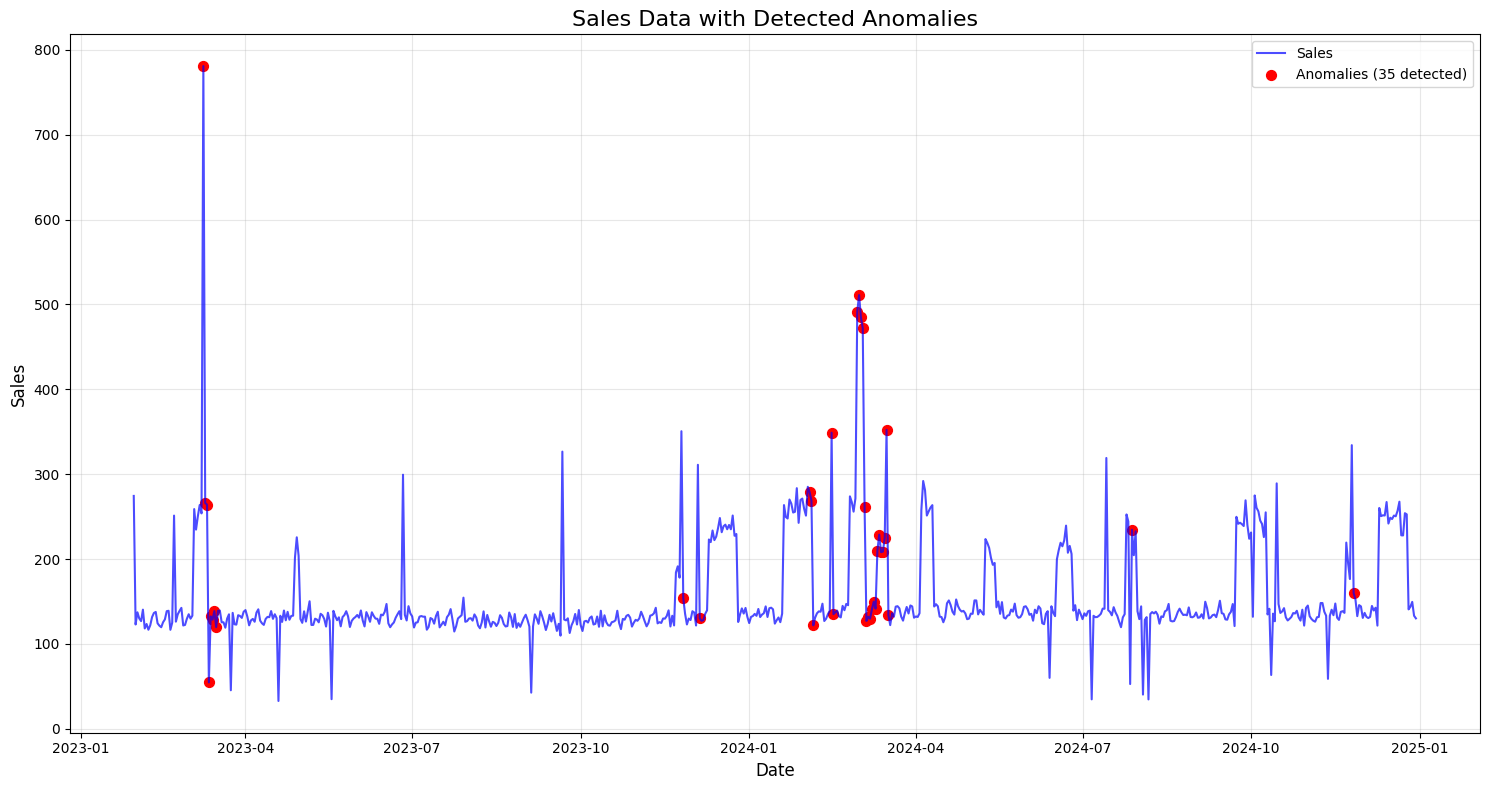

In [ ]:
# write your code from here
# write your code from here
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def generate_sample_data(n_samples=730, anomaly_percentage=0.05):
    """
    Generate sample sales data with some anomalies
    n_samples: Number of days (2 years by default)
    anomaly_percentage: Percentage of anomalies to introduce
    """
    # Set seed for reproducibility
    np.random.seed(42)
    
    # Create date range for 2 years
    start_date = datetime(2023, 1, 1)
    dates = [start_date + timedelta(days=i) for i in range(n_samples)]
    
    # Base sales pattern with weekly seasonality and general upward trend
    weekday_effect = np.array([0.8, 1.0, 1.1, 1.2, 1.3, 1.5, 0.9])  # Mon-Sun
    weekday_indices = [d.weekday() for d in dates]
    
    # Create seasonal components
    day_of_year = np.array([d.timetuple().tm_yday for d in dates])
    yearly_cycle = 0.3 * np.sin(2 * np.pi * day_of_year / 365) + 0.2  # Yearly cycle
    
    # Trend component (gradual growth)
    trend = np.linspace(0, 0.5, n_samples)
    
    # Base sales with seasonality and trend
    base_sales = 100 + 20 * np.array([weekday_effect[idx] for idx in weekday_indices]) + 15 * yearly_cycle + 30 * trend
    
    # Add random noise
    noise = np.random.normal(0, 5, n_samples)
    sales = base_sales + noise
    
    # Add some special events (peaks)
    # Black Friday effects
    black_friday_indices = []
    for year in [2023, 2024]:
        # Approximate Black Friday as Nov 25
        bf_idx = (datetime(year, 11, 25) - start_date).days
        if 0 <= bf_idx < n_samples:
            black_friday_indices.append(bf_idx)
            sales[bf_idx] *= 2.5  # Major sales spike
            # Days before and after also affected
            for i in range(1, 4):
                if bf_idx-i >= 0:
                    sales[bf_idx-i] *= (1.2 + 0.1*i)  # Ramp up
                if bf_idx+i < n_samples:
                    sales[bf_idx+i] *= (1.3 - 0.1*i)  # Ramp down
    
    # Add holiday effects (Christmas season)
    for year in [2023, 2024]:
        christmas_start = (datetime(year, 12, 10) - start_date).days
        christmas_end = (datetime(year, 12, 26) - start_date).days
        if christmas_start >= 0 and christmas_start < n_samples:
            end_idx = min(christmas_end, n_samples-1)
            sales[christmas_start:end_idx] *= 1.8
    
    # Introduce anomalies
    n_anomalies = int(n_samples * anomaly_percentage)
    anomaly_indices = np.random.choice(range(n_samples), size=n_anomalies, replace=False)
    
    # Different types of anomalies
    for idx in anomaly_indices:
        anomaly_type = np.random.choice(['drop', 'spike', 'level_shift'])
        
        if anomaly_type == 'drop':
            sales[idx] *= np.random.uniform(0.1, 0.5)  # Sharp drop
        elif anomaly_type == 'spike':
            sales[idx] *= np.random.uniform(1.8, 3.0)  # Sharp spike
        elif anomaly_type == 'level_shift':
            # Level shift affecting multiple days
            shift_length = np.random.randint(3, 10)
            if idx + shift_length < n_samples:
                sales[idx:idx+shift_length] *= np.random.uniform(1.5, 2.0)
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'sales': sales,
    })
    
    # Add features for detection
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['year'] = df['date'].dt.year
    
    # Create lag features
    for lag in [1, 7, 14]:
        df[f'sales_lag_{lag}'] = df['sales'].shift(lag)
    
    # Create rolling stats
    for window in [7, 14, 30]:
        df[f'sales_rolling_mean_{window}'] = df['sales'].rolling(window=window).mean()
        df[f'sales_rolling_std_{window}'] = df['sales'].rolling(window=window).std()
    
    # Create sales velocity and acceleration
    df['sales_velocity'] = df['sales'] - df['sales_lag_1']
    df['sales_acceleration'] = df['sales_velocity'] - df['sales_velocity'].shift(1)
    
    # Drop rows with NaN (first 30 days due to lag and rolling features)
    df = df.dropna().reset_index(drop=True)
    
    return df, anomaly_indices

def detect_anomalies(df, contamination=0.05):
    """
    Detect anomalies in sales data using Isolation Forest
    """
    # Select features for anomaly detection
    feature_columns = [col for col in df.columns if col not in ['date']]
    
    # Fill any remaining NaN values with column means
    df_features = df[feature_columns].fillna(df[feature_columns].mean())
    
    # Standardize the features
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_features)
    
    # Train isolation forest model
    model = IsolationForest(
        contamination=contamination,
        random_state=42,
        n_estimators=100
    )
    
    # Fit and predict
    df['anomaly'] = model.fit_predict(df_scaled)
    df['anomaly_score'] = model.decision_function(df_scaled)
    
    # Convert to binary and score (lower score = more anomalous)
    df['anomaly'] = np.where(df['anomaly'] == -1, 1, 0)
    
    return df

def get_feature_importance(df):
    """
    Calculate importance of each feature for anomaly detection
    using a Random Forest model
    """
    from sklearn.ensemble import RandomForestClassifier
    
    feature_columns = [col for col in df.columns if col not in ['date', 'anomaly', 'anomaly_score']]
    X = df[feature_columns]
    y = df['anomaly']
    
    # Train a random forest classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Get feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    return importance_df
def visualize_anomalies(df):
    """
    Visualize the detected anomalies
    """
    plt.figure(figsize=(15, 8))
    
    # Plot sales
    plt.plot(df['date'], df['sales'], label='Sales', color='blue', alpha=0.7)
    
    # Highlight anomalies
    anomalies = df[df['anomaly'] == 1]
    plt.scatter(anomalies['date'], anomalies['sales'], color='red', 
                label=f'Anomalies ({len(anomalies)} detected)', s=50)
    
    plt.title('Sales Data with Detected Anomalies', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sales', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt
def analyze_anomalies(df):
    """
    Analyze detected anomalies and provide insights
    """
    anomalies = df[df['anomaly'] == 1]
    
    # Group anomalies by day of week
    dow_distribution = anomalies['day_of_week'].value_counts().sort_index()
    dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_distribution.index = [dow_names[i] for i in dow_distribution.index]
    
    # Group anomalies by month
    month_distribution = anomalies['month'].value_counts().sort_index()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_distribution.index = [month_names[i-1] for i in month_distribution.index]
    
    # Calculate basic statistics for anomalies vs normal
    normal = df[df['anomaly'] == 0]
    
    stats = {
        'avg_sales_anomalies': anomalies['sales'].mean(),
        'avg_sales_normal': normal['sales'].mean(),
        'std_sales_anomalies': anomalies['sales'].std(),
        'std_sales_normal': normal['sales'].std(),
        'max_sales_anomalies': anomalies['sales'].max(),
        'min_sales_anomalies': anomalies['sales'].min(),
        'dow_distribution': dow_distribution,
        'month_distribution': month_distribution
    }
    
    return stats, anomalies

def main():
    """
    Main function to run the anomaly detection pipeline
    """
    print("Generating sample sales data...")
    df, true_anomaly_indices = generate_sample_data(n_samples=730, anomaly_percentage=0.05)
    
    print(f"Data shape: {df.shape}")
    print("\nFirst few rows of the data:")
    print(df.head())
    
    print("\nDetecting anomalies using Isolation Forest...")
    results_df = detect_anomalies(df, contamination=0.05)
    
    # Get anomaly analysis
    stats, anomalies = analyze_anomalies(results_df)
    
    print(f"\nDetected {len(anomalies)} anomalies out of {len(results_df)} data points")
    print(f"Average sales on normal days: {stats['avg_sales_normal']:.2f}")
    print(f"Average sales on anomalous days: {stats['avg_sales_anomalies']:.2f}")
    
    print("\nDay of week distribution for anomalies:")
    print(stats['dow_distribution'])
    
    print("\nMonth distribution for anomalies:")
    print(stats['month_distribution'])
    
    print("\nTop anomalies by anomaly score:")
    top_anomalies = anomalies.sort_values('anomaly_score').head(10)
    print(top_anomalies[['date', 'sales', 'anomaly_score']].to_string(index=False))
    
    # Get feature importance for the anomaly detection
    importance_df = get_feature_importance(results_df)
    print("\nFeature importance for anomaly detection:")
    print(importance_df.head(10).to_string(index=False))
    
    # Visualize the results
    plt = visualize_anomalies(results_df)
    plt.show()

if __name__ == "__main__":
    main()

**Task 2**: Using clustering algorithms to detect duplicate records where entries are not
exactly identical.

In [10]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz # For fuzzy string matching
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances
import string
import re # <--- ADDED THIS IMPORT

# Set random seed for reproducibility
np.random.seed(42)

# --- 1. Generate Synthetic Data with Fuzzy Duplicates ---
def create_fuzzy_data(num_records=100):
    base_data = [
        {"name": "John Doe", "address": "123 Main St", "city": "Anytown"},
        {"name": "Jon Doe", "address": "123 Main Street", "city": "Anytown"}, # Fuzzy duplicate of John Doe
        {"name": "Jane Smith", "address": "456 Oak Ave", "city": "Somewhere"},
        {"name": "Jane Smythe", "address": "456 Oak Avenue", "city": "Some Where"}, # Fuzzy duplicate of Jane Smith
        {"name": "Robert Johnson", "address": "789 Pine Rd", "city": "New City"},
        {"name": "Rob Johnson", "address": "789 Pine Road", "city": "Newtown"}, # Fuzzy duplicate, but city differs
        {"name": "Alice Brown", "address": "101 Elm Blvd", "city": "Old Town"}, # Unique
        {"name": "Bob White", "address": "22 Short Ln", "city": "Springfield"}, # Unique
        {"name": "Alice Brown", "address": "101 Elm Boulevard", "city": "Old Town"}, # Fuzzy duplicate of Alice Brown
        {"name": "Robert Johnson", "address": "789 Pine Road", "city": "New City"}, # Exact duplicate of Robert Johnson
    ]

    # Expand to more records, introducing some more unique ones and variations
    records = []
    for i in range(num_records):
        if i < len(base_data):
            records.append(base_data[i])
        else:
            # Add more unique or slightly varied records
            records.append({
                "name": f"Person {i}",
                "address": f"{i*10} Random St",
                "city": f"City {i % 10}"
            })
    return pd.DataFrame(records)

df = create_fuzzy_data(num_records=50) # Use a smaller number for better visualization of duplicates
print("--- Original Data Sample ---")
print(df.head(10))
print(f"\nDataFrame Shape: {df.shape}")
print("-" * 50)

# --- 2. Preprocess Data: Create a Combined, Normalized String for Comparison ---

def normalize_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip() # Replace multiple spaces with single space and strip
    return text

# Create a combined string for each record to represent its "identity"
df['combined_text'] = df['name'] + " " + df['address'] + " " + df['city']
df['normalized_text'] = df['combined_text'].apply(normalize_text)

print("\n--- Normalized Text Sample ---")
print(df[['combined_text', 'normalized_text']].head(10))
print("-" * 50)


# --- 3. Compute Similarity/Distance Matrix ---
# We'll use fuzzywuzzy's fuzz.ratio, which returns a score (0-100).
# For DBSCAN, we need a distance matrix. Distance = 100 - Score.

text_data = df['normalized_text'].tolist()
n_samples = len(text_data)

# Initialize an empty distance matrix
distance_matrix = np.zeros((n_samples, n_samples))

# Populate the distance matrix
# This can be computationally expensive for very large datasets
for i in range(n_samples):
    for j in range(i, n_samples):
        # Calculate fuzzy ratio (similarity score)
        similarity = fuzz.ratio(text_data[i], text_data[j])
        # Convert similarity to a distance (lower distance = more similar)
        distance = 100 - similarity
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance # Matrix is symmetrical

print("\n--- Sample of Distance Matrix (first 5x5) ---")
print(distance_matrix[:5, :5])
print("-" * 50)


# --- 4. Apply Clustering (DBSCAN) ---

# DBSCAN parameters:
# eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
#      If fuzz.ratio is 85, distance is 15. So, for things to be "close", eps should be relatively small.
#      A common threshold for duplicates with fuzz.ratio is 80-90, meaning distance 10-20.
# min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
#              For duplicate detection, min_samples=2 means at least two records must be within eps distance to form a cluster.
eps_threshold = 20 # Max distance for records to be considered similar (corresponds to fuzz.ratio >= 80)
min_cluster_size = 2 # Minimum records to form a duplicate group

dbscan = DBSCAN(eps=eps_threshold, min_samples=min_cluster_size, metric='precomputed')
clusters = dbscan.fit_predict(distance_matrix)

df['cluster_id'] = clusters

print(f"\n--- DBSCAN Clustering Results (eps={eps_threshold}, min_samples={min_cluster_size}) ---")
print(df[['name', 'address', 'city', 'normalized_text', 'cluster_id']].head(15))
print("-" * 50)


# --- 5. Identify and Review Duplicates ---

# Filter for clusters that have more than one member (i.e., potential duplicates)
duplicate_clusters = df[df['cluster_id'] != -1].groupby('cluster_id').filter(lambda x: len(x) > 1)

if not duplicate_clusters.empty:
    print("\n--- Identified Duplicate Records (Clustered Groups) ---")
    # Sort by cluster_id to see groups together
    duplicate_clusters = duplicate_clusters.sort_values('cluster_id')

    for cluster_id in duplicate_clusters['cluster_id'].unique():
        cluster_members = duplicate_clusters[duplicate_clusters['cluster_id'] == cluster_id]
        print(f"\nCluster ID: {cluster_id} (contains {len(cluster_members)} records)")
        for idx, row in cluster_members.iterrows():
            print(f"  - Original: Name='{row['name']}', Address='{row['address']}', City='{row['city']}'")
            print(f"    Normalized: '{row['normalized_text']}'")
else:
    print("\nNo fuzzy duplicate clusters found with the given parameters.")

print("\nRecords with cluster_id = -1 are considered noise/unique records by DBSCAN.")
print("\n--- Duplicate Detection using Clustering Complete ---")
print("\nAdjusting `eps_threshold` and `min_cluster_size` parameters will impact the sensitivity of duplicate detection:")
print(" - **Lower `eps_threshold`**: More strict similarity required for grouping (fewer, tighter clusters).")
print(" - **Higher `eps_threshold`**: More lenient similarity allowed (more, looser clusters, potentially grouping non-duplicates).")
print(" - **Higher `min_cluster_size`**: Requires more records to be close to form a cluster (can reduce false positives).")

--- Original Data Sample ---
             name            address         city
0        John Doe        123 Main St      Anytown
1         Jon Doe    123 Main Street      Anytown
2      Jane Smith        456 Oak Ave    Somewhere
3     Jane Smythe     456 Oak Avenue   Some Where
4  Robert Johnson        789 Pine Rd     New City
5     Rob Johnson      789 Pine Road      Newtown
6     Alice Brown       101 Elm Blvd     Old Town
7       Bob White        22 Short Ln  Springfield
8     Alice Brown  101 Elm Boulevard     Old Town
9  Robert Johnson      789 Pine Road     New City

DataFrame Shape: (50, 3)
--------------------------------------------------

--- Normalized Text Sample ---
                            combined_text  \
0            John Doe 123 Main St Anytown   
1         Jon Doe 123 Main Street Anytown   
2        Jane Smith 456 Oak Ave Somewhere   
3   Jane Smythe 456 Oak Avenue Some Where   
4     Robert Johnson 789 Pine Rd New City   
5       Rob Johnson 789 Pine Road Newtown 

**Task 3**: Implementing classification models to validate data based on learned
characteristics from labeled datasets.

In [11]:
# write your code from here

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set random seed for reproducibility
np.random.seed(42)

# --- 1. Synthetic Data Generation with Labeled Quality ---

def generate_data_record(record_id):
    """Generates a single data record with a chance of introducing quality issues."""
    is_valid = 1 # Assume valid by default
    age = np.random.randint(18, 70)
    income = np.random.randint(30000, 120000)
    email = f"user{record_id}@example.com"
    product_category = np.random.choice(['Electronics', 'Books', 'Clothing', 'Home Goods', 'Food'])
    transaction_amount = np.random.normal(150, 50)

    # Introduce quality issues with certain probabilities
    error_type = np.random.choice([
        'none', 'missing_age', 'invalid_email', 'outlier_income',
        'out_of_range_age', 'invalid_category', 'missing_amount'
    ], p=[0.7, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

    if error_type == 'missing_age':
        age = np.nan
        is_valid = 0
    elif error_type == 'invalid_email':
        email = f"user{record_id}example.com" # Missing @
        is_valid = 0
    elif error_type == 'outlier_income':
        income = np.random.randint(200000, 500000) # Extremely high income
        is_valid = 0
    elif error_type == 'out_of_range_age':
        age = np.random.choice([-5, 120]) # Impossible age
        is_valid = 0
    elif error_type == 'invalid_category':
        product_category = "Gadgets" # Not in our predefined list
        is_valid = 0
    elif error_type == 'missing_amount':
        transaction_amount = np.nan
        is_valid = 0

    return {
        'CustomerID': f'C{record_id:04d}',
        'Age': age,
        'Income': income,
        'Email': email,
        'ProductCategory': product_category,
        'TransactionAmount': transaction_amount,
        'is_valid': is_valid
    }

# Generate 1000 records
data_records = [generate_data_record(i) for i in range(1000)]
df = pd.DataFrame(data_records)

print("--- Synthetic Labeled Data Sample (first 10 records) ---")
print(df.head(10))
print(f"\nTotal records: {len(df)}")
print(f"Valid records: {df['is_valid'].sum()}")
print(f"Invalid records: {len(df) - df['is_valid'].sum()}")
print("-" * 50)

# --- 2. Feature Engineering for Classification ---

def create_quality_features(df_input):
    df_features = df_input.copy()

    # --- Derived Quality Flags (Binary Features) ---

    # Missingness flags
    df_features['feat_is_age_missing'] = df_features['Age'].isna().astype(int)
    df_features['feat_is_income_missing'] = df_features['Income'].isna().astype(int)
    df_features['feat_is_email_missing'] = df_features['Email'].isna().astype(int)
    df_features['feat_is_transaction_amount_missing'] = df_features['TransactionAmount'].isna().astype(int)

    # Email format validation
    email_regex = r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'
    df_features['feat_is_email_format_valid'] = df_features['Email'].apply(lambda x: bool(re.fullmatch(email_regex, str(x))) if pd.notna(x) else 0).astype(int)

    # Out-of-range checks for numerical data (assuming reasonable bounds)
    df_features['feat_is_age_out_of_expected_range'] = df_features['Age'].apply(lambda x: 1 if pd.notna(x) and (x < 0 or x > 100) else 0).astype(int)
    df_features['feat_is_income_out_of_expected_range'] = df_features['Income'].apply(lambda x: 1 if pd.notna(x) and (x < 1000 or x > 150000) else 0).astype(int)

    # Categorical consistency (check against a set of expected categories)
    expected_categories = ['Electronics', 'Books', 'Clothing', 'Home Goods', 'Food']
    df_features['feat_is_product_category_unrecognized'] = df_features['ProductCategory'].apply(lambda x: 1 if x not in expected_categories else 0).astype(int)

    # Outlier detection for TransactionAmount (using IQR for a simple method)
    Q1 = df_features['TransactionAmount'].quantile(0.25)
    Q3 = df_features['TransactionAmount'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_features['feat_is_transaction_amount_outlier'] = df_features['TransactionAmount'].apply(lambda x: 1 if pd.notna(x) and (x < lower_bound or x > upper_bound) else 0).astype(int)


    # Drop original ID, raw text columns, and the original Email column
    # We drop 'Email' because its quality aspects are captured by new binary features.
    features_to_drop = ['CustomerID', 'Email'] # 'combined_text' was for previous task, not generated here
    features_df = df_features.drop(columns=features_to_drop, errors='ignore')
    return features_df

# Apply feature engineering
df_processed = create_quality_features(df)

# Separate features (X) and target (y)
X = df_processed.drop(columns=['is_valid'])
y = df_processed['is_valid']

print("\n--- Features for Classification Model Sample (first 5 records) ---")
print(X.head())
print(f"\nFeatures DataFrame Shape: {X.shape}")
print("-" * 50)

# --- 3. Data Splitting ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)} records")
print(f"Test set size: {len(X_test)} records")
print("-" * 50)

# --- 4. Model Training ---

# Identify numerical and categorical features for preprocessing pipeline
# Ensure 'Email' is NOT in these lists. It is now handled by the drop in create_quality_features.
numerical_features = ['Age', 'Income', 'TransactionAmount']
categorical_features = ['ProductCategory']

# Add the derived binary quality flags to numerical features for pipeline processing
quality_flags = [col for col in X.columns if col.startswith('feat_')]
numerical_features.extend(quality_flags)

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute NaNs in numerical columns
    ('scaler', StandardScaler()) # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Impute NaNs in categorical
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # 'remainder' should now only contain columns to keep as-is, if any.
                            # In this case, it should be empty or contain irrelevant non-feature columns
                            # that RandomForest can ignore (which is fine if they are numerical).
)

# Create the full machine learning pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')) # Use class_weight for imbalanced classes
])

# Train the model
print("\n--- Training Classification Model ---")
model_pipeline.fit(X_train, y_train)
print("Model training complete.")
print("-" * 50)

# --- 5. Model Evaluation ---
print("\n--- Evaluating Model Performance on Test Set ---")
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probability of being valid

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Invalid (0)', 'Valid (1)']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"True Positives (Valid Correctly Classified): {cm[1, 1]}")
print(f"False Positives (Invalid Classified as Valid): {cm[0, 1]}") # This is data quality issue missed!
print(f"True Negatives (Invalid Correctly Classified): {cm[0, 0]}")
print(f"False Negatives (Valid Classified as Invalid): {cm[1, 0]}") # This is valid data flagged as invalid!

print("\nInterpretation of Confusion Matrix for Data Quality:")
print(" - **True Negatives (TN)**: The model correctly identified truly *invalid* records. (Good for data quality!)")
print(" - **False Positives (FP)**: The model incorrectly classified *invalid* records as *valid*. This is a critical error for data quality, as bad data slips through.")
print(" - **True Positives (TP)**: The model correctly identified truly *valid* records. (Good.)")
print(" - **False Negatives (FN)**: The model incorrectly classified *valid* records as *invalid*. This is a less critical error, leading to unnecessary manual review or data loss.")
print("-" * 50)


# --- 6. Predict on New Data ---
print("\n--- Predicting Data Quality for New, Unseen Records ---")

# Create a few new records, some valid, some invalid
new_data = pd.DataFrame([
    # Example 1: Clearly valid record
    {'CustomerID': 'C1001', 'Age': 35, 'Income': 75000, 'Email': 'test@example.com', 'ProductCategory': 'Books', 'TransactionAmount': 120.50},
    # Example 2: Invalid (missing age)
    {'CustomerID': 'C1002', 'Age': np.nan, 'Income': 60000, 'Email': 'another@domain.net', 'ProductCategory': 'Clothing', 'TransactionAmount': 200.00},
    # Example 3: Invalid (bad email format)
    {'CustomerID': 'C1003', 'Age': 40, 'Income': 80000, 'Email': 'bademail.com', 'ProductCategory': 'Electronics', 'TransactionAmount': 300.00},
    # Example 4: Invalid (out of range age)
    {'CustomerID': 'C1004', 'Age': 150, 'Income': 90000, 'Email': 'qa@test.org', 'ProductCategory': 'Home Goods', 'TransactionAmount': 50.00},
    # Example 5: Invalid (unrecognized product category)
    {'CustomerID': 'C1005', 'Age': 28, 'Income': 45000, 'Email': 'sample@mail.co', 'ProductCategory': 'Furniture', 'TransactionAmount': 75.00},
    # Example 6: Valid record (close to an error but still valid)
    {'CustomerID': 'C1006', 'Age': 55, 'Income': 110000, 'Email': 'valid.user@test.org', 'ProductCategory': 'Food', 'TransactionAmount': 85.00},
])

# Apply the same feature engineering to the new data
# Note: The `is_valid` column is not needed for prediction, so we omit it or drop it
new_data_for_prediction = create_quality_features(new_data.drop(columns=['is_valid'], errors='ignore'))

# Predict the quality of new data
new_predictions = model_pipeline.predict(new_data_for_prediction)
new_probabilities = model_pipeline.predict_proba(new_data_for_prediction)[:, 1] # Probability of being valid

new_data['Predicted_is_valid'] = new_predictions
new_data['Probability_valid'] = new_probabilities

print("\n--- Predicted Quality for New Records ---")
print(new_data[['CustomerID', 'Age', 'Email', 'ProductCategory', 'Predicted_is_valid', 'Probability_valid']])
print("\nInterpretation: 'Predicted_is_valid' of 1 means the model classifies it as valid, 0 as invalid.")
print("The Probability_valid column gives confidence in the prediction.")
print("-" * 50)

--- Synthetic Labeled Data Sample (first 10 records) ---
  CustomerID    Age  Income              Email ProductCategory  \
0      C0000   56.0   45795  user0@example.com            Food   
1      C0001  120.0   67194  user1@example.com        Clothing   
2      C0002   57.0   46023  user2@example.com        Clothing   
3      C0003   38.0  113104  user3@example.com      Home Goods   
4      C0004   61.0   55658  user4@example.com           Books   
5      C0005   61.0   86886  user5@example.com      Home Goods   
6      C0006   20.0   99092  user6@example.com        Clothing   
7      C0007   42.0  103969  user7@example.com           Books   
8      C0008   19.0   53483  user8@example.com         Gadgets   
9      C0009   53.0   97121  user9@example.com      Home Goods   

   TransactionAmount  is_valid  
0         177.187158         1  
1         119.228512         0  
2         126.526281         1  
3         177.128002         1  
4         137.447802         1  
5         141.8066